# An Automated Monte Carlo Simulation of Stocks
## Final Project DATA 618
### Vanita Thompson

## Background

There are many sophisticated models that can be built for forecasting problems. In this project, I will explore how a Monte Carlo Simulation can be applied in practice.  In particular, we will see how we can run a simulation when trying to predict the future stock price of a company.This approach can produce a better understanding of the range of potential outcomes and help avoid the “flaw of averages”.  

The Monte Carlo Simulations are a class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle. They are often used in financial and mathematical problems and are most useful when it is difficult or impossible to use other approaches. Monte Carlo methods are mainly used in three problem classes: optimization, integration, and probability distribution.

Monte Carlo simulations are used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. This technique can be used to understand the impact of risk and uncertainty in prediction and forecasting models. It is also referred to as multiple probability simulation.


In this notebook, we explore how to use Monte Carlo simulations for forecasting future stock prices.

$$
{Current Price}={Past Price * e^r}
$$

We want to use past prices to predict current pricing. What we do not know is the rate of return, r, of the share price between past and current. This is what the Monte Carlo simulation is useful for.

### Brownian Motion

Brownian motion will be the main driver for estimating the return. It is a stochastic process used for modeling random behavior over time. Typically, the Geometric Brownian Motion is used in stock pricing applications. For simplicity, we will use browinian motion

**Brownian Motion** has two main main components:
1. Drift - the direction that rates of returns have had in the past. That is, the expected return of the stock.
$$
{Drift} = ({mean} - \frac{1}{2} {Var})
$$

    Why do we multiply the variance by 0.5? Because historical values are eroded in the future.
    

2. Volatility -  random variable. This is the historical volatility multiplied by a random, standard normally distributed variable.

$$
{Volatility} = {Std.Dev. * Z([Rand(0;1)])}
$$

Therefore, our asset pricing equation ends up looking like this:

$$
{Price Today}={Price Yesterday * e^{mean-\frac{1}{2}{Var} + Std.Dev * Z([Rand(0;1)])}}
$$


In [22]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime

%matplotlib inline

## Part 1: Simple Monte Carlo Simulation

In [25]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

### Data Import & Analysis

The company we will use for our analysis will be Apple (AAPL). The timeframe under consideration reflects the past 8 months, starting from January the 3rd 2020.

In [29]:
start=dt.datetime(2020,1,3)
end=dt.datetime(2020,9,20)

prices=web.DataReader('AAPL','yahoo', start, end)['Close']
prices.head()

Date
2020-01-03    74.357498
2020-01-06    74.949997
2020-01-07    74.597504
2020-01-08    75.797501
2020-01-09    77.407501
Name: Close, dtype: float64

In the below plot, we see that Apple stock has been increasing steadily through the years.

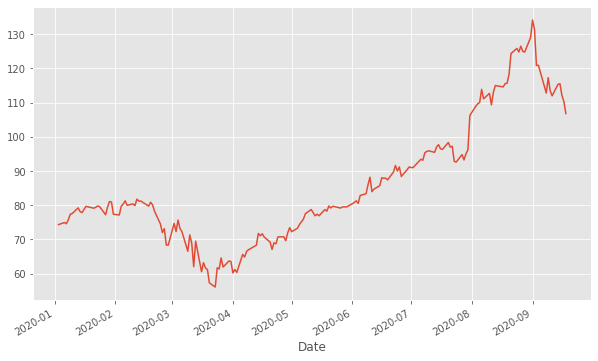

In [30]:
prices.plot(figsize=(10, 6));

We want to forecast Apple’s future stock price in this exercise. So, the first thing we’ll do is estimate its historical log returns. The method we’ll apply here is called “percent change”, and you must write “pct_change()” to obtain the simple returns from a provided dataset. We can create the formula for log returns by using NumPy’s log and then type 1 + the simple returns extracted from our data. Below is a table with Apple’s log returns.

In [34]:
returns=prices.pct_change()
returns

Date
2020-01-03         NaN
2020-01-06    0.007968
2020-01-07   -0.004703
2020-01-08    0.016086
2020-01-09    0.021241
                ...   
2020-09-14    0.030000
2020-09-15    0.001560
2020-09-16   -0.029514
2020-09-17   -0.015964
2020-09-18   -0.031720
Name: Close, Length: 180, dtype: float64

In [35]:
last_price=prices[-1]
last_price

106.83999633789062

In [36]:
log_returns = np.log(1 + prices.pct_change())
log_returns.tail()

Date
2020-09-14    0.029559
2020-09-15    0.001559
2020-09-16   -0.029958
2020-09-17   -0.016092
2020-09-18   -0.032234
Name: Close, dtype: float64

In the below graph, we have plotted the log returns, not the price, of Apple. The picture tells us the returns are normally distributed and have a stable mean. 

Text(0, 0.5, 'Frequency')

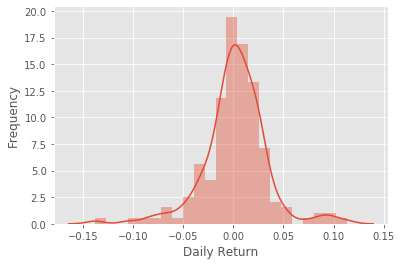

In [37]:
import seaborn as sns
log_return = np.log(1 + prices.pct_change())
#Plot
sns.distplot(log_returns.iloc[1:])
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

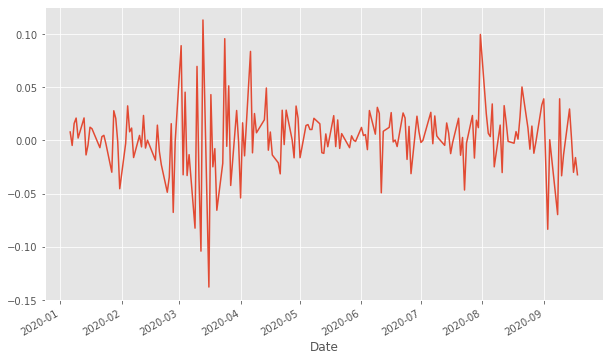

In [38]:
log_returns.plot(figsize=(10, 6));

### Predicting the Daily Return of a Stock


Now, we will explore their mean and variance, as we will need them for the calculation of the Brownian motion.
We need to know how to calculate mean and variance.Next, we will create a variable, called “stdev”, and we will assign to it the standard deviation of log returns. We said the Brownian motion comprises the sum of the drift and a variance adjusted by “E” to the power of “R”, so we will use this block in the second part of the expression.

In [39]:
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5 * var)
stdev = log_returns.std()

0.0020248482487600977

In [45]:
print("u, var: ", log_returns.mean(), log_returns.var())
print("drift, stdev: ", u - (0.5 * var) , log_returns.std())

u, var:  0.0020248482487600977 0.0010280524956860174
drift, stdev:  0.001510822000917089 0.032063257721042904


We’ve examined the first Brownian motion element in our simulation.Next, we will create the second component and will show you how this would allow us to run a simulation about a firm’s future stock price. Until now, we obtained the “drift” and standard deviation values we will need for the calculation of daily returns. To proceed with our task, we should convert these values into NumPy arrays and begin the simulation below.

## Simulation

Now that we have built these tools and calculated all necessary variables, we are ready to calculate daily returns. I would like to specify the time intervals we will use will be 1,000, because we are interested in forecasting the stock price for the upcoming 1,000 days. The variable 'num_days' includes the days the stock market was open, excluding 9 holidays and weekends.

In [46]:
# number of simulation
num_simulations=1000
num_days=259

In [47]:
simulation_df=pd.DataFrame()

Finally, we can generate values for our simulation. The simulation will generate values foor the expected stock price. We must set up a loop that begins in day 1 and ends at day 1,000. We can simply write down the formula for the expected stock price on day T in Pythonic. It will be equal to the price in day T minus 1, times the daily return observed in day T.

In [48]:
for x in range(num_simulations):
    count=0
    daily_vol=returns.std()
    
    price_series=[]
    price=last_price*(1+np.random.normal(0,daily_vol))
    price_series.append(price)
    
    for y in range(num_days):
        if count==258:
            break
        price=price_series[count]*(1+np.random.normal(0,daily_vol))
        price_series.append(price)
        count+=1
    
    simulation_df[x]=price_series

Below is a dataframe of predictions of stock prices from our above simulation.

In [49]:
simulation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,101.736835,108.112531,106.905221,107.809701,105.023035,111.535246,105.047730,103.813513,101.737290,109.147587,...,108.164392,109.689448,110.110488,101.119575,105.213023,103.642087,99.535997,110.056358,108.659015,108.993935
1,100.037085,112.152063,102.119706,105.377327,106.205477,108.327621,104.101230,105.107964,108.142144,105.626246,...,109.980112,109.475156,108.097266,94.974654,108.145387,102.105470,101.688702,111.409351,108.609398,111.969847
2,100.089773,110.138502,101.764009,100.618129,102.255791,104.123987,106.707842,106.654689,107.618464,110.826137,...,110.278995,107.353628,109.368924,90.672307,106.558525,99.677101,99.966552,114.033376,103.146366,108.696016
3,100.327297,109.907742,100.933816,97.444891,106.118519,97.433711,107.025700,107.079535,104.300808,110.930276,...,110.597536,100.717985,107.629489,92.379378,108.141030,104.155039,95.778146,112.120503,97.462017,104.101627
4,104.415583,107.470072,99.657370,92.805564,97.816302,99.976003,108.256264,108.033535,107.191062,108.969550,...,109.580370,101.094737,106.357691,95.521541,115.981082,108.597969,95.166203,118.597605,98.563813,104.901894


With the help of the “i-loc” method and the index operator, we can indicate we need the last value from the table.

In [50]:
simulation_last_day=simulation_df.iloc[258,:]
simulation_last_day

0      100.086615
1      178.274825
2      253.081062
3       64.732828
4       97.892585
          ...    
995    114.855783
996    123.731511
997     91.005632
998     46.178163
999     53.884984
Name: 258, Length: 1000, dtype: float64

In [51]:
simulation_last_day.mean()

106.60010306507137

In [52]:
simulation_last_day.describe()

count    1000.000000
mean      106.600103
std        56.737408
min        21.982859
25%        64.885037
50%        94.498392
75%       132.560024
max       427.454597
Name: 258, dtype: float64

### Data Visualization

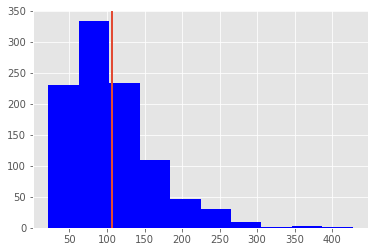

In [53]:
plt.hist(simulation_last_day, bins=10, color='b')
plt.axvline(x=simulation_last_day.mean(),linewidth=2)
plt.show()

This histogram above shows a right-skewed, or positive-skewed distribution. On a right-skewed histogram, the mean, median, and mode are all different. In this case, the mode is the highest point of the histogram, whereas the median and mean fall to the right of it (or, visually, the right of the peak). Note that the mean will always be to the right of the median.

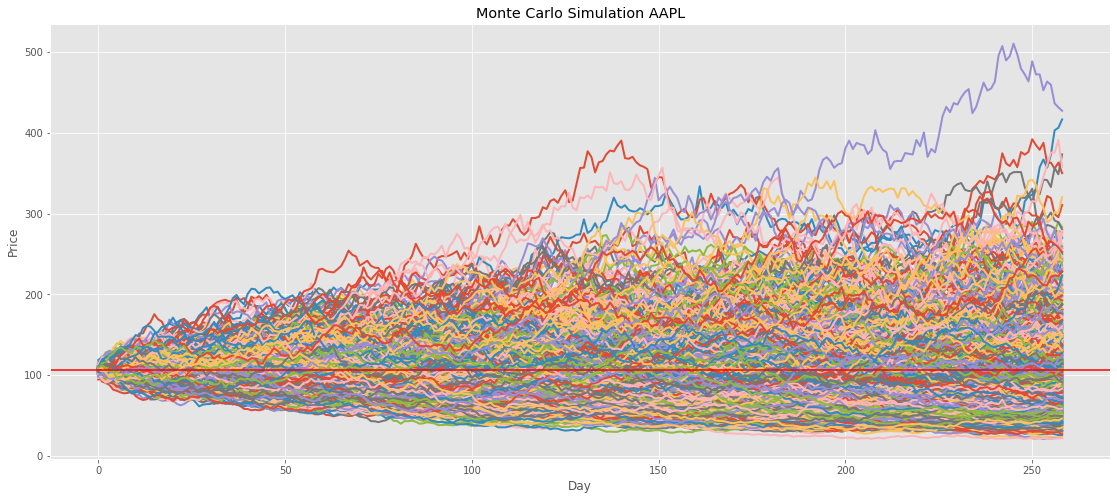

In [54]:
fig=plt.figure(figsize=(19,8))
plt.plot(simulation_df, linewidth=2)
plt.title('Monte Carlo Simulation AAPL')
plt.xlabel('Day')
plt.ylabel('Price')
plt.axhline(y=last_price, color='r', linestyle='-')
plt.show()

## Part 2: Automated Multiple Stock Simulation with CAPM and Sharpe Metrics

This automated technique will be used for every day in the future you want to predict. In Part 1,  we focused on running a single stock simulation. For this part, we will use the monte carlo simulation for any number of trials for multiple stocks at once.

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime

%matplotlib inline

Import data for one or multiple stocks from a specified date until the last available data. Data source: yahoo finance.

For this, it's better if we define a function that imports stock(s) daily data for any publicly traded company as defined by the user starting at a user-defined date until today. We will use the Adjusted Close price.

In [55]:
def import_stock_data(tickers, start = '2010-1-1', end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [71]:
data = import_stock_data(['TSLA'])

Then, we compute the logarithmic returns of the data.

In [72]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [73]:
log_return = log_returns(data)

We also create a function to compute the simple returns.

In [74]:
def simple_returns(data):
    return ((data/data.shift(1))-1)

## CAPM and Sharpe

Before we jump into Monte Carlo Simulations, we would like to report some statistics with it, including the Beta and Sharpe Ratio of the stock, compared to the _market portfolio_. To understand these metrics, we first must understand the underlying concepts of the _Capital Asset Pricing Model,_ starting with the _market portfolio_.

* The market portfolio is the theoretical combination of all possible investments in the world. However, there is no such thing as a market portfolio. We approximate it with a stock market index. In our case, we use the S&P500, but you can specify any index you want to!

* We also note that there is no such thing as a risk-free asset. We will use a 10-year US government bond yield of 2.5% instead.

* The equity premium is the difference between the expected return of the market and the risk-free asset. This value is typically between 4.5 and 5.5%. We can use 5%.

We use the _market portfolio_ to compute the Beta, the CAPM expected return, and the Sharpe Ratio of a stock.
1. **Beta**: measures the market risk that cannot be avoided through diversification. This is the relationship between the stock and the market portfolio. In other words, it is a measure of how much risk the investment will add to a portfolio that looks like the market.
##### $$ 
\beta_{i} = \frac{\sigma_{i,m}}{\sigma_{m}^2}
$$

        When beta = 0, it means that there's no relationship.
    
        When beta < 1, it means that the stock is defensive (less prone to high highs and low lows)
    
        When beta > 1, it means that the stock is aggresive (more prone to high highs and low lows)
    
    
2. **Expected Return CAPM**: calculates the expected return of a security adjusted to the risk taken. This equates to the return expected from taking the extra risk of purchasing this security.
##### $$
\overline{r_{i}} = r_f + \beta_{i}(\overline{r_{m}} - r_f) 
$$

3. **Sharpe Ratio**: measures the performance of a security compared to a risk-free asset, after adjusting for its risk. This is the excess return per unit of risk of an investment.
##### $$
Sharpe = \frac{\overline{r_{i}} - r_f}{\sigma_{i}}
$$
        When Sharpe > 1, GOOD risk-adjusted returns
    
        When Sharpe > 2, VERY GOOD risk-adjusted returns
    
        When Sharpe > 3, EXCELLENT risk-adjusted returns
    

In [75]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    market_data = import_stock_data(mark_ticker, start)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [76]:
def beta_sharpe(data, mark_ticker = "^GSPC", start='2010-1-1', riskfree = 0.025):
    
    """
    Input: 
    1. data: dataframe of stock price data
    2. mark_ticker: ticker of the market data you want to compute CAPM metrics with (default is ^GSPC)
    3. start: data from which to download data (default Jan 1st 2010)
    4. riskfree: the assumed risk free yield (US 10 Year Bond is assumed: 2.5%)
    
    Output:
    1. Dataframe with CAPM metrics computed against specified market procy
    """
    # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start)
    log_ret = log_returns(dd)
    covar = log_ret.cov()*252
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    mrk_var = log_ret.iloc[:,-1].var()*252
    beta = covar/mrk_var
    
    stdev_ret = pd.DataFrame(((log_ret.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [77]:
beta_sharpe(data)

,Beta,STD,CAPM,Sharpe
TSLA,1.280037,0.55861,0.138824,0.203762


**Brownian Motion**

Now that we have our returns, we can compute the brownian motion, as explained in the introduction.
1. Calculate the drift
2. Calculate the variance
3. Calculate the daily returns based on the drift and variance

In [78]:
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [79]:
drift_calc(data)

array([0.00123204])

We calculated the drift above, but now, we must calculate the daily returns for the data. There are things to consider:
1. How many days into the future will we predict? (How many rows)
2. How many iterations of these predictions will we compute? (How many columns)

This generates the daily returns (not prices!) for each day into the future for each iteration (simulation) based on a normal distribution.

In [80]:
def daily_returns(data, days, iterations, return_type='log'):
    ft = drift_calc(data, return_type)
    if return_type == 'log':
        try:
            stv = log_returns(data).std().values
        except:
            stv = log_returns(data).std()
    elif return_type=='simple':
        try:
            stv = simple_returns(data).std().values
        except:
            stv = simple_returns(data).std()    
    #Oftentimes, we find that the distribution of returns is a variation of the normal distribution where it has a fat tail
    # This distribution is called cauchy distribution
    dr = np.exp(ft + stv * norm.ppf(np.random.rand(days, iterations)))
    return dr

In [81]:
dr = daily_returns(data, 2, 3)

**Note**: This next function is used to calculate the probability of a stock having a higher price or higher returns than specified over the period defined. 

In [82]:
def probs_find(predicted, higherthan, on = 'value'):
    """
    This function calculated the probability of a stock being above a certain threshhold, which can be defined as a value (final stock price) or return rate (percentage change)
    Input: 
    1. predicted: dataframe with all the predicted prices (days and simulations)
    2. higherthan: specified threshhold to which compute the probability (ex. 0 on return will compute the probability of at least breakeven)
    3. on: 'return' or 'value', the return of the stock or the final value of stock for every simulation over the time specified
    """
    if on == 'return':
        predicted0 = predicted.iloc[0,0]
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
        less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
    elif on == 'value':
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [i for i in predList if i >= higherthan]
        less = [i for i in predList if i < higherthan]
    else:
        print("'on' must be either value or return")
    return (len(over)/(len(over)+len(less)))

Example: We would like to find out the probability that our investment in PG will breakeven or make a profit over the course of a year (financial year is about 252 days). There are two ways we can do this:
1. Returns = 0
2. Final stock price = initial stock price ($44.05 - Jan 1st 2010, the first data point)

So, with the simulation predicted values, we will predict said probabilities.

---

First, however, we must run the simulation! How does it work?

1. Calculate the daily returns for every day and every iteration (simulation) of the data. 
2. Creates an equally large matrix of size [days x iteration] full of zeroes.
3. Input the last stock price value in the first row (day 0) of the "empty" matrix (part 2). This is our starting point.
4. Calculate "today's price" based on yesterday's multiplied by the daily return generated. That is, multiply the daily return generated for every simulation with the stock price calculated for the previous day (the previous row) for every simulation.

Does that sounds familiar? The fourth step multiplies the daily returns with the price of the stock of the previous day!

In [85]:
def simulate_mc(data, days, iterations, return_type='log', plot=True):
    # Generate daily returns
    returns = daily_returns(data, days, iterations, return_type)
    # Create empty matrix
    price_list = np.zeros_like(returns)
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    # Calculate the price of each day
    for t in range(1,days):
        price_list[t] = price_list[t-1]*returns[t]
    
    # Plot Option
    if plot == True:
        x = pd.DataFrame(price_list).iloc[-1]
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        sns.distplot(x, ax=ax[0])
        sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
        plt.xlabel("Stock Price")
        plt.show()
    
    #CAPM and Sharpe Ratio
    
    # Printing information about stock
    try:
        [print(nam) for nam in data.columns]
    except:
        print(data.name)
    print(f"Days: {days-1}")
    print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
    print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
    print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
          
    return pd.DataFrame(price_list)

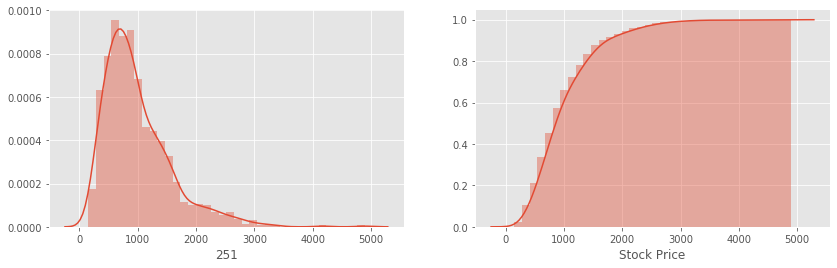

TSLA
Days: 251
Expected Value: $990.07
Return: 35.78%
Probability of Breakeven: 0.708


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,635.830017,635.830017,635.830017,635.830017,635.830017,635.830017,635.830017,635.830017,635.830017,635.830017,...,635.830017,635.830017,635.830017,635.830017,635.830017,635.830017,635.830017,635.830017,635.830017,635.830017
1,648.694712,640.094346,633.305075,632.679746,660.839740,694.476990,640.277375,635.203408,610.783112,656.340973,...,629.187603,652.599119,646.100824,629.293092,641.144381,640.985920,659.866497,665.157017,643.871216,685.080800
2,639.230273,686.058974,635.943537,642.449248,663.146983,674.915539,670.357124,656.800170,644.586187,628.835005,...,666.562975,651.214522,691.210020,655.406905,673.153648,636.092999,666.422274,671.350228,627.595399,687.161666
3,623.162065,704.851390,651.052691,692.761387,705.610572,680.637512,733.657056,659.956754,631.396727,650.445494,...,642.393490,684.562737,690.521411,660.647841,684.354272,633.554376,665.921461,655.448032,651.955250,652.164108
4,598.378199,704.540813,621.221513,709.697836,757.410138,680.509662,747.260998,706.066810,630.576718,696.307043,...,620.105861,684.396060,681.926436,662.932933,667.780597,641.747625,694.218715,645.358962,641.505449,688.828408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,478.183390,1581.904743,638.475669,968.281605,2126.759280,535.129341,795.658005,438.212407,525.242202,1419.729385,...,1488.208841,881.819746,2126.289227,733.060819,1200.092616,468.899888,1749.172999,701.411846,2904.217309,759.565444
248,482.687544,1586.014592,666.516557,966.274483,2094.455508,547.095291,792.633505,423.918295,516.221984,1510.522743,...,1463.392560,907.688331,2011.989782,722.397674,1238.293380,475.647466,1732.126623,733.463234,2901.358759,779.019403
249,492.090638,1535.737267,671.457298,1021.915957,2079.140269,559.547590,776.820168,381.760626,519.558675,1573.250188,...,1414.325200,944.899051,1928.714886,743.656885,1222.783854,458.172944,1763.578416,749.345020,2907.828870,765.097858
250,497.511775,1640.261394,691.714703,1006.479097,2093.092357,590.631318,792.772763,379.683473,513.102304,1534.835274,...,1500.844244,919.515007,1858.984914,781.372112,1217.169603,459.669822,1785.583842,758.639069,2723.237655,825.751845


In [86]:
simulate_mc(data, 252, 1000, 'log')

Now, let's loop through all the stated securities and generate the visualizations and statistics that will help us understand the expected performance of a stock.

In [87]:
def monte_carlo(tickers, days_forecast, iterations, start_date = '2000-1-1', return_type = 'log', plotten=False):
    data = import_stock_data(tickers, start=start_date)
    inform = beta_sharpe(data, mark_ticker="^GSPC", start=start_date)
    simulatedDF = []
    for t in range(len(tickers)):
        y = simulate_mc(data.iloc[:,t], (days_forecast+1), iterations, return_type)
        if plotten == True:
            forplot = y.iloc[:,0:10]
            forplot.plot(figsize=(15,4))
        print(f"Beta: {round(inform.iloc[t,inform.columns.get_loc('Beta')],2)}")
        print(f"Sharpe: {round(inform.iloc[t,inform.columns.get_loc('Sharpe')],2)}") 
        print(f"CAPM Return: {round(100*inform.iloc[t,inform.columns.get_loc('CAPM')],2)}%")
        y['ticker'] = tickers[t]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
    simulatedDF = pd.concat(simulatedDF)
    return simulatedDF

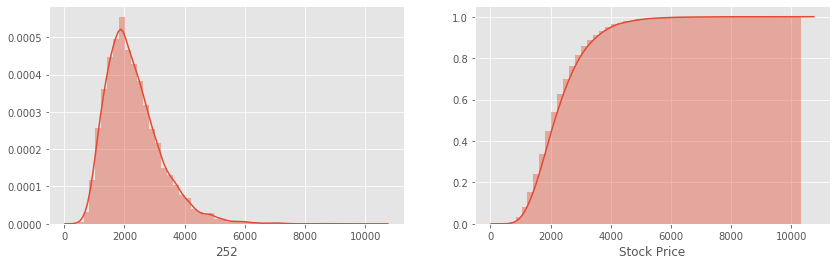

GOOG
Days: 252
Expected Value: $2296.24
Return: 23.23%
Probability of Breakeven: 0.691
Beta: 0.94
Sharpe: 0.27
CAPM Return: 13.22%


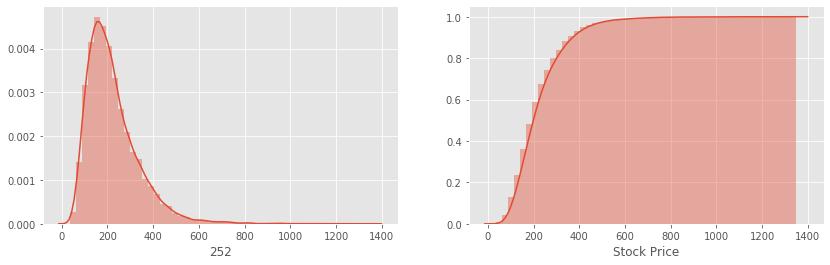

AAPL
Days: 252
Expected Value: $223.26
Return: 43.19%
Probability of Breakeven: 0.8249
Beta: 1.12
Sharpe: 0.27
CAPM Return: 15.21%


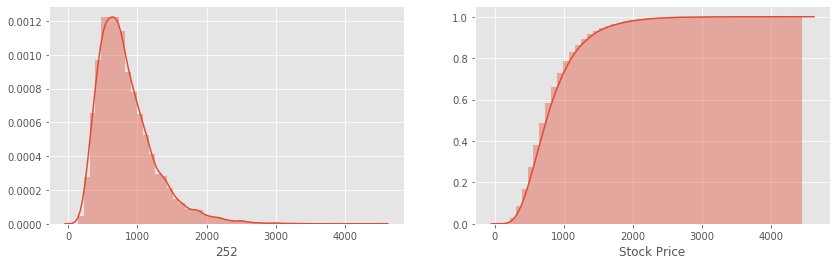

NFLX
Days: 252
Expected Value: $836.74
Return: 38.06%
Probability of Breakeven: 0.7807
Beta: 0.66
Sharpe: 0.16
CAPM Return: 9.98%


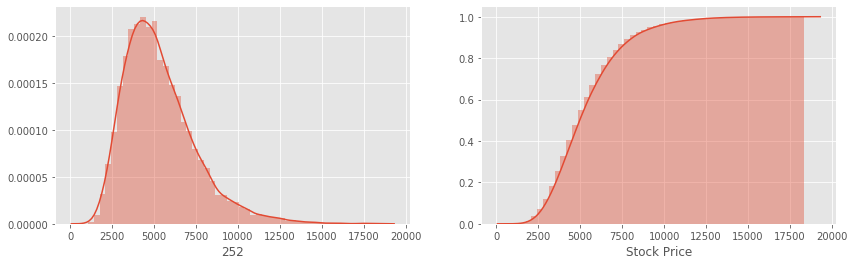

AMZN
Days: 252
Expected Value: $5337.95
Return: 41.04%
Probability of Breakeven: 0.8756
Beta: 0.68
Sharpe: 0.2
CAPM Return: 10.2%


In [90]:
start = "2020-1-1"
days_to_forecast= 252
simulation_trials= 10000
ret_sim_df = monte_carlo(['GOOG','AAPL', 'NFLX', 'AMZN'], days_forecast= days_to_forecast, iterations=simulation_trials,  start_date=start, plotten=False)

In [92]:
ret_sim_df.head()

,ticker,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,GOOG,1762.880005,1762.880005,1762.880005,1762.880005,1762.880005,1762.880005,1762.880005,1762.880005,1762.880005,...,1762.880005,1762.880005,1762.880005,1762.880005,1762.880005,1762.880005,1762.880005,1762.880005,1762.880005,1762.880005
1,GOOG,1730.952982,1803.356853,1768.843202,1711.412343,1831.090343,1719.133679,1780.287721,1755.204433,1773.411492,...,1783.805907,1748.837227,1764.639414,1727.326133,1819.737124,1803.506500,1773.254722,1753.028642,1730.863726,1805.461124
2,GOOG,1697.953400,1766.049884,1829.035553,1732.529966,1853.692507,1693.759294,1824.727197,1787.345872,1723.677833,...,1811.115126,1776.819306,1700.363802,1725.751877,1817.470131,1949.514917,1794.120315,1738.912412,1701.932082,1749.769522
3,GOOG,1762.445161,1666.836763,1853.388719,1745.673660,1847.158307,1780.690321,1839.359768,1754.385856,1709.318568,...,1858.359558,1796.499573,1717.165490,1709.055814,1845.668521,2001.308425,1879.754524,1662.282901,1686.165113,1793.302101
4,GOOG,1765.160131,1648.476993,1870.550217,1688.165155,1932.373977,1804.504731,1816.890174,1727.882936,1744.520018,...,1864.033552,1784.351001,1654.833427,1676.112430,1872.388434,1996.290027,1905.985577,1568.358598,1674.013692,1856.919131


## Discussion

We have successfuly run a Monte Carlo simulation that predicts Apple’s stock price 258 days into the future.
Additionally, I will include price_paths matrix,n calculate the probability of profitability, the expected annualized returm, and the expected daily return. Additionally, we will take a look at running multiple stock simulations at once, and We will also display some metrics from the Capital Asset Pricing Model (CAPM).

## Citations

https://pbpython.com/monte-carlo.html
https://www.investopedia.com/terms/m/montecarlosimulation.asp
https://towardsdatascience.com/the-house-always-wins-monte-carlo-simulation-eb82787da2a3